### Using tf.data for Multiple Files

In [1]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorboard.plugins.hparams import api as hp
import keras_tuner as kt
import numpy as np
import pickle
from tensorflow.keras import utils as np_utils

from sklearn.preprocessing import MinMaxScaler
# Load the TensorBoard notebook extension
%load_ext tensorboard
# Clear any logs from previous runs

SHUFFLE_BUFFER = 500
BATCH_SIZE = 128

In [2]:
print("TensorFlow version: {}".format(tf.__version__))
print("Eager execution: {}".format(tf.executing_eagerly()))

TensorFlow version: 2.5.0
Eager execution: True


In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))
# [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

print(tf.test.is_built_with_cuda)
# <function is_built_with_cuda at 0x7f4f5730fbf8>

print(tf.test.gpu_device_name())
# /device:GPU:0

print(tf.config.get_visible_devices())

Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
<function is_built_with_cuda at 0x00000189058F80D0>
/device:GPU:0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
df = pd.read_csv("edit_fixture_edit_players.csv",encoding='latin-1')

In [5]:
CATEGORIES = ['HOME', 'AWAY', 'DRAW'] # 0 = home, 0.5 = draw, 1 = away


In [6]:
pd.set_option('max_rows', None)
pd.set_option('max_columns', None)

In [7]:
df.head()

,fixture_id,home_id,h_elo,h_attack,h_defence,away_id,a_elo,a_attack,a_defence,result,h_Shots_on_Goal,h_Shots_off_Goal,h_Total_Shots,h_Blocked_Shots,h_Shots_insidebox,h_Shots_outsidebox,h_Fouls,h_Corner_Kicks,h_Ball_Possession,h_Goalkeeper_Saves,h_Total_passes,h_Passes_accurate,h_Passing_accuracy,a_Shots_on_Goal,a_Shots_off_Goal,a_Total_Shots,a_Blocked_Shots,a_Shots_insidebox,a_Shots_outsidebox,a_Fouls,a_Corner_Kicks,a_Ball_Possession,a_Goalkeeper_Saves,a_Total_passes,a_Passes_accurate,a_Passing_accuracy,h_0,h_1,h_2,h_3,h_4,h_5,h_6,h_7,h_8,h_9,h_10,a_0,a_1,a_2,a_3,a_4,a_5,a_6,a_7,a_8,a_9,a_10
0,65,33,1701.999982,1.465662,-0.509711,46,1499.785559,1.574221,-1.981735,0.0,3.0,4.2,10.6,3.4,6.2,4.4,8.2,4.6,55.6,2.4,568.0,488.0,83.4,5.2,4.0,11.6,2.4,8.0,3.6,10.4,4.2,52.0,2.0,405.0,306.6,75.6,882.0,887.0,889.0,891.0,885.0,901.0,904.0,905.0,899.0,910.0,909.0,2728.0,18774.0,2935.0,18771.0,2933.0,114.0,3421.0,18786.0,18781.0,18784.0,2778.0
1,66,34,1484.325864,1.080315,-0.996740,47,1735.523910,2.262229,-0.981297,1.0,4.0,5.6,13.2,3.6,7.2,6.0,9.8,3.2,46.6,1.4,430.4,322.8,72.6,5.8,4.2,14.6,4.6,8.4,6.2,8.6,5.2,64.2,2.8,577.2,481.8,83.4,18886.0,18891.0,18894.0,18892.0,18897.0,18904.0,18898.0,18903.0,18902.0,18907.0,18906.0,159.0,170.0,163.0,164.0,168.0,179.0,174.0,178.0,172.0,175.0,184.0
2,67,35,1477.638408,1.309383,-1.821893,43,1484.035903,-0.045547,-0.167265,0.0,4.0,7.0,15.6,4.6,9.2,6.4,8.6,7.4,47.6,3.4,428.0,335.2,77.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18858.0,18864.0,18869.0,18863.0,18861.0,18879.0,18874.0,18873.0,18870.0,2939.0,18881.0,18983.0,18994.0,18991.0,18986.0,18992.0,18987.0,18993.0,19004.0,19003.0,19007.0,19008.0
3,68,36,1485.130306,-0.030110,-0.157769,52,1503.018276,1.689230,-1.204394,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.4,4.6,11.8,3.8,6.6,5.2,11.0,4.6,48.0,3.6,390.2,294.2,75.4,19011.0,19019.0,19017.0,19015.0,19016.0,19029.0,19031.0,19025.0,3243.0,19032.0,2825.0,18836.0,18842.0,18844.0,18845.0,18843.0,18846.0,18849.0,18854.0,18852.0,2928.0,3247.0
4,69,37,1425.731483,0.373948,-1.192954,49,1644.610836,1.526170,-1.143879,1.0,2.4,6.8,14.6,5.4,8.8,5.8,9.8,7.2,56.2,2.2,481.8,374.8,76.4,3.0,4.0,10.6,3.6,6.8,4.0,10.6,3.0,51.0,2.8,531.8,444.4,83.0,19038.0,2731.0,19044.0,19045.0,19043.0,19042.0,19049.0,19050.0,19051.0,2734.0,3395.0,2273.0,2283.0,2280.0,2278.0,2285.0,2287.0,2289.0,2290.0,2294.0,2299.0,59.0


In [8]:
df.dtypes

fixture_id              int64
home_id                 int64
h_elo                 float64
h_attack              float64
h_defence             float64
away_id                 int64
a_elo                 float64
a_attack              float64
a_defence             float64
result                float64
h_Shots_on_Goal       float64
h_Shots_off_Goal      float64
h_Total_Shots         float64
h_Blocked_Shots       float64
h_Shots_insidebox     float64
h_Shots_outsidebox    float64
h_Fouls               float64
h_Corner_Kicks        float64
h_Ball_Possession     float64
h_Goalkeeper_Saves    float64
h_Total_passes        float64
h_Passes_accurate     float64
h_Passing_accuracy    float64
a_Shots_on_Goal       float64
a_Shots_off_Goal      float64
a_Total_Shots         float64
a_Blocked_Shots       float64
a_Shots_insidebox     float64
a_Shots_outsidebox    float64
a_Fouls               float64
a_Corner_Kicks        float64
a_Ball_Possession     float64
a_Goalkeeper_Saves    float64
a_Total_pa

In [ ]:
target = df.pop('result')
print(target)

In [10]:
target.value_counts()


0.0    6439
1.0    4482
0.5    3532
Name: result, dtype: int64

In [ ]:
home = []
away = []
draw = []
for i in range(len(target)):
    if (target[i]==0.0):
        home.append(target[i])
    elif (target[i]==1.0):
        away.append(target[i])
    elif (target[i]==0.5):
        target[i]=2.0
        draw.append(target[i])
        
print(len(home))
print(len(away))
print(len(draw))
for i in range(len(draw)):
    print(draw[i])

In [12]:
tf.convert_to_tensor(df)

<tf.Tensor: shape=(14453, 57), dtype=float64, numpy=
array([[6.50000000e+01, 3.30000000e+01, 1.70199998e+03, ...,
        1.87810000e+04, 1.87840000e+04, 2.77800000e+03],
       [6.60000000e+01, 3.40000000e+01, 1.48432586e+03, ...,
        1.72000000e+02, 1.75000000e+02, 1.84000000e+02],
       [6.70000000e+01, 3.50000000e+01, 1.47763841e+03, ...,
        1.90030000e+04, 1.90070000e+04, 1.90080000e+04],
       ...,
       [7.05681000e+05, 1.91000000e+02, 1.50786184e+03, ...,
        2.53490000e+04, 2.48030000e+04, 2.86200000e+03],
       [7.05682000e+05, 2.40000000e+02, 1.41787466e+03, ...,
        2.48600000e+04, 3.32500000e+03, 3.33200000e+04],
       [7.05683000e+05, 2.26000000e+02, 1.47748874e+03, ...,
        4.19300000e+04, 4.11880000e+04, 4.11390000e+04]])>

In [13]:
#normalizer = tf.keras.layers.experimental.preprocessing.Normalization(axis=-1)
#normalizer.adapt(df)
scaler = MinMaxScaler()
df = scaler.fit_transform(df)

In [14]:
#normalizer(df.iloc[:3])


In [15]:
x_train, x_val, y_train, y_val = train_test_split(df, target, test_size = 0.4, random_state=42)

In [16]:
print(len(x_train))
display(x_train)
print(y_val.value_counts())
print(x_train[0])

8671


array([[0.86232211, 0.36556604, 0.38324217, ..., 0.10334259, 0.10386294,
        0.10962562],
       [0.05064497, 0.04323899, 0.2091332 , ..., 0.06910431, 0.00996769,
        0.01200556],
       [0.28814458, 0.39465409, 0.29630491, ..., 0.35122515, 0.        ,
        0.04688089],
       ...,
       [0.03407793, 0.14465409, 0.43246984, ..., 0.13970586, 0.13884597,
        0.14907347],
       [0.0045903 , 0.12814465, 0.2028945 , ..., 0.12475368, 0.12534659,
        0.01028279],
       [0.13239883, 0.03459119, 0.25382948, ..., 0.07288096, 0.07325152,
        0.07931922]])

0.0    2578
1.0    1797
2.0    1407
Name: result, dtype: int64
[0.86232211 0.36556604 0.38324217 0.42119054 0.45511803 0.36320755
 0.24572431 0.27418407 0.29520427 0.4        0.37333333 0.44666667
 0.21666667 0.40952381 0.3        0.49586777 0.30666667 0.60309278
 0.3        0.53778308 0.47135757 0.85869565 0.2295082  0.31428571
 0.30718954 0.2        0.30851064 0.24       0.51666667 0.18333333
 0.61298701 0.36666667 0.55193176 0.50210025 0.88596491 0.10919167
 0.07207317 0.01093581 0.10626084 0.107559   0.01015845 0.10223813
 0.13559247 0.11166029 0.05709548 0.09863715 0.00292069 0.00832226
 0.09783697 0.10737405 0.10792384 0.00657563 0.00502267 0.01003194
 0.10334259 0.10386294 0.10962562]


In [17]:
print(len(y_train))
print(y_train.value_counts())

8671
0.0    3861
1.0    2685
2.0    2125
Name: result, dtype: int64


In [18]:
print(len(x_val))
print(len(y_val))

5782
5782


In [19]:
x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size = 0.5, random_state=42)

In [ ]:
dummy_y = np_utils.to_categorical(y_train)
print(dummy_y[:100])
# 0 = home = 100, 1 = away = 010, 2 = draw =001

In [21]:
len(x_val)

2891

In [22]:
len(y_val)

2891

In [23]:
print(len(x_test))
print(len(y_test))

2891
2891


In [ ]:
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Flatten())
    # Tune the number of layers.
    for i in range(hp.Int("num_layers", 1, 6)):
        model.add(
            layers.Dense(
                # Tune number of units separately.
                
                units=hp.Int(f"units_{i}", min_value=32, max_value=256, step=32),
                activation=hp.Choice("activation", ["relu", "tanh"]),
            )
        )
    
        print(i)
    if hp.Boolean("dropout"):
        model.add(layers.Dropout(rate=0.25))
    model.add(layers.Dense(3, activation="softmax")) #hier sigmoid statt softmax aus tutprial da binary und anzahl Klassen anstatt 10
    learning_rate = hp.Float("lr", min_value=1e-3, max_value=1e-2, sampling="log")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss="sparse_categorical_crossentropy", # https://stackoverflow.com/questions/61742556/valueerror-shapes-none-1-and-none-2-are-incompatible
        metrics=["accuracy"],
    )
    return model


build_model(kt.HyperParameters())

In [25]:
tuner = kt.BayesianOptimization(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=200,
    executions_per_trial=3,
    overwrite=True,
    directory="edit_fixture_edit_players",
    project_name="helloworld",
)

0


In [26]:
tuner.search_space_summary()

Search space summary
Default search space size: 5
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 6, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': None}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
dropout (Boolean)
{'default': False, 'conditions': []}
lr (Float)
{'default': 0.001, 'conditions': [], 'min_value': 0.001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [27]:
tuner.search(x_train, y_train, epochs=20, validation_data=(x_val, y_val))

Trial 200 Complete [00h 00m 30s]
val_accuracy: 0.5428340832392374

Best val_accuracy So Far: 0.5466390053431193
Total elapsed time: 02h 14m 15s
INFO:tensorflow:Oracle triggered exit


In [27]:
tuner.results_summary()

Results summary
Results in edit_fixture_edit_players\helloworld
Showing 10 best trials
Objective(name='val_accuracy', direction='max')


In [28]:
hp = kt.HyperParameters()
learning_rate = hp.Float("lr", min_value=1e-3, max_value=1e-2, sampling="log")
optimizer=keras.optimizers.Adam(learning_rate=learning_rate)
best_hps=tuner.get_best_hyperparameters(num_trials=1)
#print(best_hps)
best_model = tuner.get_best_models(num_models=1)
checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=best_model)
#tf.train.Checkpoint.restore(...).expect_partial()
#to_be_predicted = np.array([[[0.6579319133419915,1666.6615077675299,0.18500000000000003,-0.37750000000000006,0,6.795720454545455,0.4803987065096406,1653.0341501069572,0.18500000000000003,-0.6725000000000001,0,6.8410482]]])
#y_prob = best_model[0].predict(x_train)
#best_model[0].summary()
#print(y_prob)

In [ ]:
best_model[0].save('best_model_edit_fixture_edit_player')

In [30]:
file_to_store = open("stored_object.pickle", "wb")
pickle.dump(tuner, file_to_store)

file_to_store.close()

In [31]:
file_to_read = open("stored_object.pickle", "rb")


loaded_tuner = pickle.load(file_to_read)


file_to_read.close()
print(loaded_tuner)

In [32]:
loaded_tuner.results_summary()

Results summary
Results in edit_fixture_edit_players\helloworld
Showing 10 best trials
Objective(name='val_accuracy', direction='max')


In [33]:
loaded_model = keras.models.load_model('best_model_edit_fixture_edit_player')

In [34]:
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 57)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                1856      
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 99        
Total params: 1,955
Trainable params: 1,955
Non-trainable params: 0
_________________________________________________________________


In [35]:
loaded_model.layers[1].get_config()

{'name': 'dense',
 'trainable': True,
 'dtype': 'float32',
 'units': 32,
 'activation': 'relu',
 'use_bias': True,
 'kernel_initializer': {'class_name': 'GlorotUniform',
  'config': {'seed': None}},
 'bias_initializer': {'class_name': 'Zeros', 'config': {}},
 'kernel_regularizer': None,
 'bias_regularizer': None,
 'activity_regularizer': None,
 'kernel_constraint': None,
 'bias_constraint': None}

In [36]:
loaded_model.optimizer.get_config()

{'name': 'Adam',
 'learning_rate': 0.001,
 'decay': 0.0,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-07,
 'amsgrad': False}

In [ ]:
correct_prediction = 0
false_prediction = 0
y_true = []
y_pred = []
for i in range(len(x_test)):
   
    to_be_predicted = np.array([x_test[[i]]])
    y_prob = loaded_model.predict(to_be_predicted)
    
    result = y_test.iloc[[i][0]]
    predicted_result = np.argmax(y_prob) # wähle result mit
    #y_true.append(str(CATEGORIES[int(result)]))
    #y_pred.append(str(CATEGORIES[predicted_result]))
    y_true.append(result)
    y_pred.append(predicted_result)
    if(int(result) == predicted_result):
        print(f"Match {i}")
        print("result: " + str(CATEGORIES[int(result)]))
        print("prediction: " + str(CATEGORIES[predicted_result]))
        correct_prediction = correct_prediction+1
    #print(y_prob[0][0])
    #print(y_prob[0][1])
    #print(y_prob[0][2])
    #print(f"result number {i}: " + str(y_val.iloc[[i][0]]))
    else:
        print(f"No Match: {i}")
        print("result: " + str(CATEGORIES[int(result)]))
    #print("prediction number "+ str(np.argmax(y_prob)))
        print("prediction: " + str(CATEGORIES[predicted_result]))
        false_prediction = false_prediction+1
print("correct: "+ str(correct_prediction) + "/" + str(len(x_test)))
print("correct: " +str(correct_prediction/len(x_test)))
print("false: "+ str(false_prediction) + "/" + str(len(x_test)))
print("false: " +str(false_prediction/len(x_test)))

In [39]:
classes=[0.0, 1.0, 2.0]
confusion_matrix(y_true, y_pred, labels=[0.0, 1.0, 2.0])



array([[1044,  218,    0],
       [ 423,  481,    0],
       [ 501,  224,    0]], dtype=int64)

In [39]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('tatsächliches Ergebnis')
    plt.xlabel('vorhergesagtes Ergebnis')
    plt.tight_layout()

Confusion matrix, without normalization
[[1044  218    0]
 [ 423  481    0]
 [ 501  224    0]]


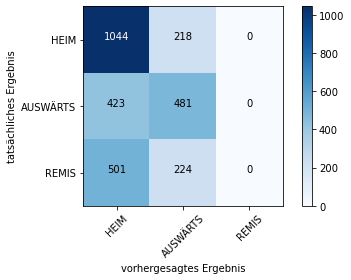

In [40]:
cnf_matrix = confusion_matrix(y_true, y_pred, labels=[0.0, 1.0, 2.0])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['HEIM', 'AUSWÄRTS', 'REMIS'],
                      title='')

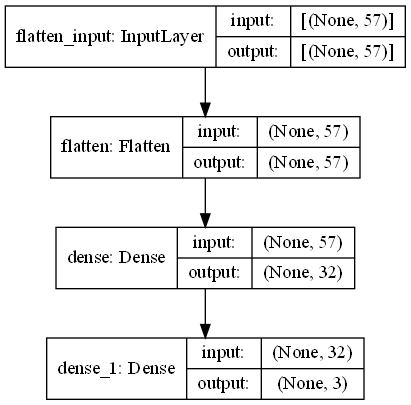

In [47]:
tf.keras.utils.plot_model(loaded_model, to_file="Bild_model.png", show_shapes=True)

In [42]:
FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix) 
FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
TP = np.diag(cnf_matrix)
TN = cnf_matrix.sum() - (FP + FN + TP)
FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)
# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)
# Overall accuracy for each class
ACC = (TP+TN)/(TP+FP+FN+TN)

C:\Users\Anwender\AppData\Local\Temp/ipykernel_13624/1338496663.py:14: RuntimeWarning: invalid value encountered in true_divide
  PPV = TP/(TP+FP)
C:\Users\Anwender\AppData\Local\Temp/ipykernel_13624/1338496663.py:22: RuntimeWarning: invalid value encountered in true_divide
  FDR = FP/(TP+FP)


In [43]:
#Genauigkeit
print(ACC)

[0.6  0.7  0.75]


In [44]:
#Präzision
print(PPV)

[0.53 0.52  nan]


In [45]:
#Trefferquote
print(TPR)

[0.83 0.53 0.  ]


In [46]:
#F-Maß
F_SCORE= (2 * PPV * TPR)/(PPV+TPR)
print(F_SCORE)

[0.65 0.53  nan]


In [38]:
print(len(y_test))
y_test.value_counts()

2891


0.0    1262
1.0     904
2.0     725
Name: result, dtype: int64